# Introduction

In this post, I train Karpathy's __[nanoGPT](https://johncollinsai-nanogpt-voqqf4ls3a-as.a.run.app/)__ on high-frequency (tick-by-tick) data for __[AAPL](https://www.google.com/search?q=aapl&oq=AAPL&aqs=chrome.0.0i512l5j69i61l3.1590j1j9&sourceid=chrome&ie=UTF-8)__ and __[JPM](https://www.google.com/search?q=jpm+stock+price&oq=JPM+stock+pri&aqs=chrome.0.0i512j69i57j0i512l8.4577j1j9&sourceid=chrome&ie=UTF-8)__. I want to see how nanoGPT performs as a volatility predictor.  I also want to explore the use of LLMs for tasks, in this case volatility prediction, that are typically performed by models more specific to finance.  In the case of volatility prediction, the established model classes include stochastic volatility models such as the __[MSM](https://github.com/johncollinsai/markov-switching-multifractal)__ of Calvet & Fisher, ARCH and GARCH, and Jump Diffusion models. More recently deep learning has been applied to volatility prediction and this __[post](https://johncollinsai-deep-learning-finance-voqqf4ls3a-as.a.run.app/)__ describes these developments in some detail. However, the application of LLMs to volatility prediction appears to be quite novel and the use of nanoGPT provides a great basis for an under-the-hood examination.

I begin with __[my earlier implementation of Karpathy's nanoGPT](https://github.com/johncollinsai/nanogpt)__. Starting with a very simple bigram language model, following Karpathy, I define and build a transformer piece by piece. Then I train it on a rigorously prepared tick-by-tick price dataset. In order to negate or reduce the impact of microstructure noise, and in particular Bid-Ask bounce, I compute a weighted mid-price using the CloseBid and CloseAsk prices and sizes. I discuss microstructure noise, Bid-Ask bounce, weighted mid-price, and my motivation for using it, in detail in my post __[high frequency data](https://johncollinsai-high-frequency-data-voqqf4ls3a-as.a.run.app)__.  I obtain returns from the WMP and, for tractability, log returns.

My code for this post is arranged in following python files:

* volgpt_data.py imports the OHLC data from NYSE TAQ and preprocesses it

* [BRIEFLY DESCRIBE THE REST OF THE FUNCTIONS IN THE ORDER IN WHICH THEY ARE USED]

I use an NVIDIA GeForce RTX 3080 Ti Laptop GPU and a deep learning framework that includes PyTorch, CUDA, cuDNN, and NVIDIA Drivers, on Ubuntu 22.04 LTS.  Source code as always may be found on __[my GitHub](https://github.com/johncollinsai/nanogpt)__.

#### Import high-frequency data, prepare, describe and visualize it

device: cuda
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU
df_data_AAPL.shape:  (533860, 8)
df_data_JPM.shape:  (537011, 8)
no missing_rows_AAPL rows with missing values
no missing_rows_JPM rows with missing values
shape of df_data_AAPL:  (533860, 8)
shape of df_exported_AAPL:  (533860, 9)
shape of df_data_JPM:  (537011, 8)
shape of df_exported_JPM:  (537011, 9)

Descriptive statistics for AAPL:  
Number of observations =  444470 
Minimum, Maximum =  (-152.83124999999998, 165.5690434782609) 
Mean = -0.00017 
Variance = 4.54474 
Standard deviation = 2.13184 
Skewness = 1.33822 
Kurtosis = 2684.83480 

Descriptive statistics for JPM:  
Number of observations =  332093 
Minimum, Maximum =  (-39.10681818181817, 50.888157894736835) 
Mean = -0.00007 
Variance = 0.38692 
Standard deviation = 0.62203 
Skewness = -1.59559 
Kurtosis = 1684.46534


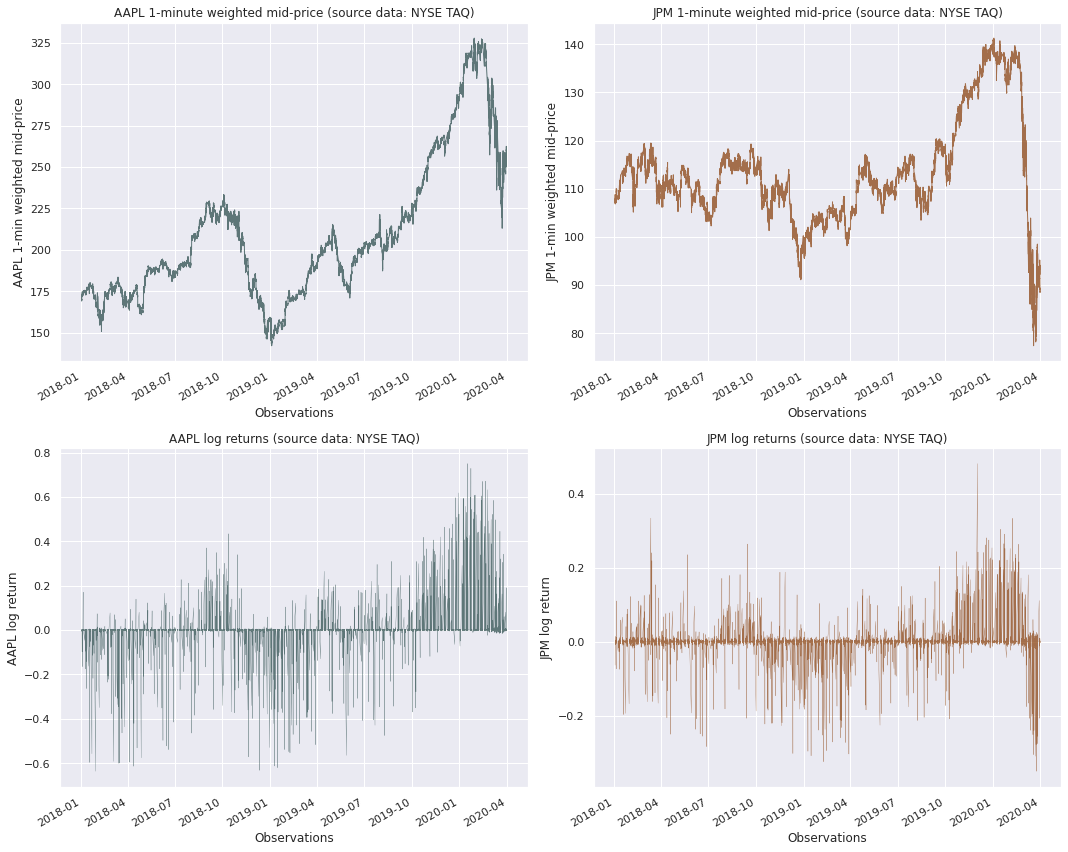

In [1]:
# import the high frequency OHLC data from NYSE TAQ, prepare it
from volgpt_describe import volgpt_import, volgpt_describe 
df_data_AAPL, df_data_JPM, AAPL_rr, JPM_rr, AAPL_lr, JPM_lr, AAPL_stats, JPM_stats, device = volgpt_import(dp=8) # set dp

# describe and visualize the data
volgpt_describe(AAPL_stats, JPM_stats, df_data_AAPL, df_data_JPM, AAPL_lr, JPM_lr)

#### Train NanoGPT and generate new high-frequency data

The basic mechanics here are:

* The decode() function is used to convert the output produced by m.generate() from the list of token IDs to a human-readable string. The output of m.generate() is a tensor of long integers, which is converted to a Python list with .tolist(). Then, the resulting list is passed as an argument to decode(), which uses volGPT's trained bigram language model to convert the token IDs to the corresponding text representations. Finally, the output of decode() is assigned to the variable generated_text.

* I generate 50k tokens, and then decode the tokens into a string. The output string, pred, contains a list of financial data points, including stock names (e.g., AAPL, JPM), timestamps, and the various numerical values. Each row of data starts with the stock symbol (e.g., AAPL or JPM), followed by a timestamp. After the timestamp, the other data are separated by commas. 

* Note that I generate 50k tokens because I need a lot of generated text to get datetimestamps that align between the generated high frequency data and the real high frequency data

In [2]:
# Train the model on AAPL and JPM OHLC data and use it to generate high-frequency data in the form of text
from volgpt import train_and_generate
text_file_path = 'df_data_AAPL.txt' # specify the path to the text file
max_iters = 6000
learning_rate = 1e-4
max_new_tokens=50000 # Set max_new_tokens sufficiently high that date-time stamps match the original data

test_data, generated_text, itos = train_and_generate(text_file_path,
                                                     max_iters=max_iters,
                                                     learning_rate=learning_rate,
                                                     device=device,
                                                     max_new_tokens=max_new_tokens)

# print the first 10 lines of generated text
print('\n'.join(generated_text.splitlines()[:10]))
# print(generated_text)

0.207149 M parameters
step 0: train loss 3.9630, val loss 3.9613, test loss 3.9599
step 100: train loss 1.6206, val loss 1.6177, test loss 1.5886
step 200: train loss 1.1799, val loss 1.1919, test loss 1.1916
step 300: train loss 1.0185, val loss 1.0271, test loss 1.0123
step 400: train loss 0.9441, val loss 0.9492, test loss 0.9446
step 500: train loss 0.9114, val loss 0.9123, test loss 0.9245
step 600: train loss 0.8843, val loss 0.8874, test loss 0.8774
step 700: train loss 0.8742, val loss 0.8835, test loss 0.8753
step 800: train loss 0.8666, val loss 0.8682, test loss 0.8532
step 900: train loss 0.8685, val loss 0.8625, test loss 0.8631
step 1000: train loss 0.8363, val loss 0.8307, test loss 0.8450
step 1100: train loss 0.8358, val loss 0.8436, test loss 0.8334
step 1200: train loss 0.8317, val loss 0.8255, test loss 0.8271
step 1300: train loss 0.8261, val loss 0.8253, test loss 0.8329
step 1400: train loss 0.8269, val loss 0.8153, test loss 0.8282
step 1500: train loss 0.8213, 

#### Observations re model training

* Under this set up volGPT (this implementation of Karpathy's nanoGPT I shall call volGPT to align with some of the annotation in my code and make this implementation distinct from __[my earlier implementation of Karpathy's nanoGPT](https://github.com/johncollinsai/nanogpt)__), has 0.207149 million parameters, which is of course very small compared to large-scale language models like GPT-3. This means the model might have less capacity to learn complex patterns in the data.

* Both the training loss and validation loss decrease steadily over time, suggesting that the model is learning from the data and generalizing to the validation set. The validation loss values are relatively close to the training loss values throughout the training process, indicating that the model is not overfitting significantly. However, the difference between the two losses seems to grow slightly larger in the later stages of training, which could be an indication that the model starts to overfit.

* The final training loss, on the run when I wrote this, is 0.7112, and the final validation loss is 0.8379. These values indicate that the model is performing reasonably well, as the losses have decreased significantly from their initial values. Nevertheless, I cannot tell if the model is underfitting without comparing its performance to other models or baselines, which goes beyond the purposes of this post.

#### Cleaning the high-frequency data generated by volGPT and setting up the model evaluation

* It is necessary to clean the generated data, so in that respect it is no different to real OHLC data!

* The clean_data function is responsible for cleaning and preprocessing the input data. It takes in a raw text data containing financial information and, optionally, column names. It then processes the data by removing invalid rows, converting data types, and returning the cleaned DataFrame alongside the original DataFrame and a list of invalid rows.

* The volgpt_stats function is responsible for evaluating the performance of a model's predictions. It takes in generated text (predictions), test data, and an index-to-string (itos) mapping. The function cleans both the generated text and the test data using the clean_data function and merges the cleaned data. I align the timing of the predictions and the test data. If the model's predictions and the test data have different time steps, it is not possible to accurately calculate the MSE and MAE; the function therefore ensures that both datasets are aligned in terms of their time steps before calculating the performance metrics. Finally it calculates performance metrics, specifically the Mean Squared Error (MSE), Mean Absolute Error (MAE), and performs paired t-tests. The function then prints the results and returns the cleaned generated data, cleaned test data, merged data, and various calculated statistics.

* In summary, the clean_data function is a utility function used by the volgpt_stats function to preprocess the input data before performing performance evaluation.

#### Evaluate the model: MSE, MAE, and paired t-test 

I evaluate the accuracy of the raw return and log return predictions by the model using MSE and MAE. To briefly recap:

* Mean Squared Error (MSE) measures the average squared difference between the predicted values and the actual values. A lower MSE indicates better accuracy.

* Mean Absolute Error (MAE) measures the average absolute difference between the predicted values and the actual values. This metric is less sensitive to outliers compared to MSE.

I perform a hypothesis test to compare the performance of two models or evaluate the significance of the model's errors, using a paired t-test.

* The paired t-test determines if there is a significant difference between the true values and the predicted values. If the p-value is small (typically below 0.05), it suggests that the difference is significant, and the model's errors are not likely due to random chance.


In [3]:
# clean generated high-frequency data currently in text form, convert to numeric form and evaluate the model
from volgpt_stats import volgpt_stats
generated_clean, test_data_clean, merged_data, rr_mae, rr_mse, lr_mae, lr_mse, raw_t_stat, raw_p_value, log_t_stat, log_p_value = volgpt_stats(generated_text, test_data, itos)

Outputs from volgpt_stats function: 
-----------------------------------

Clean generated data: 
          DateTimeIndex Ticker  CloseBidSize  CloseAskSize  CloseBidPrice  CloseAskPrice  WeightedMidPrice          rr          lr
1   2018-02-21 04:36:00   AAPL         100.0         300.0         188.86         188.08        188.950000  188.050000  188.902686
2   2018-08-11 04:51:00   AAPL         100.0         400.0         193.96         193.87        193.800000  193.975000    0.000000
4   2020-07-01 10:13:00   AAPL         100.0         100.0         181.54         181.70        181.590000  181.700000  181.514546
5   2020-03-24 01:55:00   AAPL         700.0         400.0         162.45         162.40        162.580000  162.571424   -0.027692
7   2018-07-24 08:36:00   AAPL         100.0         600.0         191.24         191.21        191.257607    0.002485    0.000056
..                  ...    ...           ...           ...            ...            ...               ...         ..

#### Results [NEED TO BE UPDATED]

* The merged data shows the predicted/generated returns (rr_generated, lr_generated) and the actual/test returns (rr_test, lr_test). It is important to note that the generated data has a date range from 2010-07-29 to 2030-09-07, while the test data has a date range from 2018-01-02 to 2020-02-19. This means that the generated data covers a broader time range and might have different market conditions than the test data.

* Raw returns MSE and MAE values, as well as log returns MSE and MAE values, are still relatively low. This indicates that the prediction model is fairly accurate on average. However, to better assess the performance of the model, it would be helpful to compare these metrics against a suitable benchmark, such as a naive forecasting model or other established models in the field.

* Paired t-test results: With the additional context, it's worth noting that the p-values for both raw returns and log returns are still greater than the commonly used significance level of 0.05. This means there is no strong evidence to reject the null hypothesis that the true and predicted values have the same mean. This suggests that the prediction model is not significantly different from the true values.

#### Conclusions

* The results suggest that a text-to-text LLM trained on high-frequency OHLC data can perform well as a volatility predictor, at least as well as the number-to-number asset pricing models traditionally used for this task.

* What this work appears to show is that it is possible to convert numbers to text and train a LLM to understand the patterns in the data that enable forward prediction of volatility with a level accuracy that is comparible if not better than asset pricing models built specifically for this and similar purposes.  This has potentially quite profound implications for asset pricing and risk management and further study, including head-to-head comparison of LLMs to traditional asset pricing models, is likely to be a fertile area for researchers.

# References

Bollerslev, T., Hood, B., Huss, J., Pedersen, L.H. (2017). Risk Everywhere: Modeling and Managing Volatility. Available at SSRN: https://ssrn.com/abstract=2722591

Calvet, L.E. & Fisher, A.J. (2008).  Multifractal Volatility Theory, Forecasting, and Pricing.  Elsevier, Academic Press.

__[Colab for Kaparthy's video](https://colab.research.google.com/drive/1JMLa53HDuA-i7ZBmqV7ZnA3c_fvtXnx-?usp=sharing)__

__[Kaparthy's nanoGPT GitHub repo](https://github.com/karpathy/nanoGPT)__

__[Kaparthy's Youtube video](https://www.youtube.com/watch?v=kCc8FmEb1nY)__

Stoikov, S. (2020). The micro-price: A high frequency estimator of future prices. Available at SSRN: https://ssrn.com/abstract=2970694.

Vaswani, A., et al. (2017).  Attention Is All You Need. arXiv:1706.03762

***
End